In [ ]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np

In [ ]:
# Load the dataset
file_path = "./carprices.csv"
df = pd.read_csv(file_path)

In [ ]:
#list and drop columns that are less related to the target based on my judgement
cols_to_drop = ['transmission','sellingprice','saledate','vin']
# Drop multiple columns by name
df = df.drop(cols_to_drop, axis=1)

In [ ]:
df.isnull().sum()

,0
year,0
make,10301
model,10399
trim,10651
body,13195
state,0
condition,11820
odometer,94
color,749
interior,749


In [ ]:
df = df.dropna(subset=['state','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [ ]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 1


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
Q1 = df['mmr'].quantile(0.25)
Q3 = df['mmr'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['mmr'] < lower_bound) | (df['mmr'] > upper_bound)]

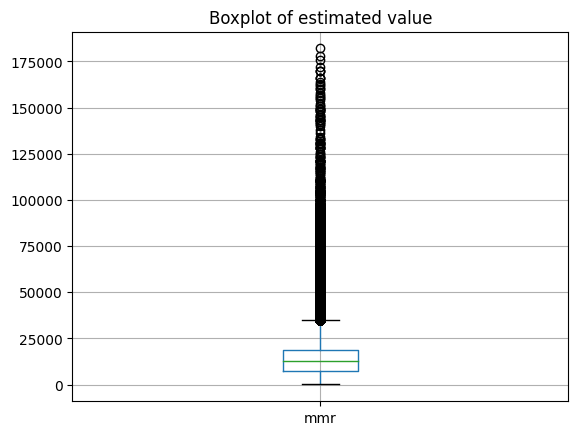

In [ ]:
df[['mmr']].boxplot()
plt.title('Boxplot of estimated value')
plt.show()

In [ ]:
df = df[(df['mmr'] >= lower_bound) & (df['mmr'] <= upper_bound)]

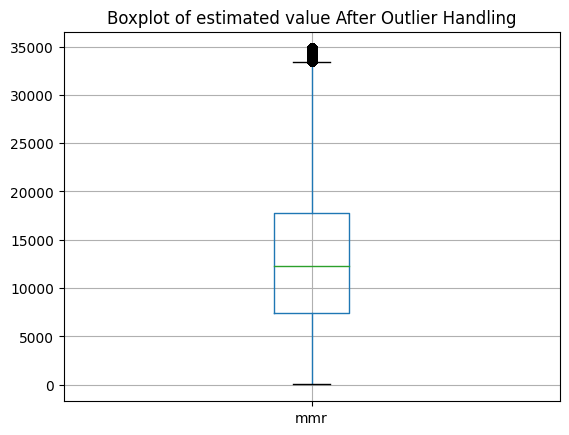

In [ ]:
df[['mmr']].boxplot()
plt.title('Boxplot of estimated value After Outlier Handling')
plt.show()

In [ ]:
df.shape

(517499, 12)

In [ ]:
# Define the categorical columns to be one-hot encoded
categorical_columns = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller']

In [ ]:
frequency_counts = df['make'].value_counts()
print(frequency_counts)

make
Ford             90018
Chevrolet        57126
Nissan           53007
Toyota           38714
Dodge            29955
Honda            26367
Hyundai          21372
Kia              17807
BMW              16969
Chrysler         16910
Infiniti         14609
Jeep             14608
Mercedes-Benz    14539
Volkswagen       12156
Lexus            10924
GMC               9809
Mazda             8171
Cadillac          6771
Acura             5645
Lincoln           5445
Subaru            4931
Buick             4908
Audi              4880
Pontiac           4244
Mitsubishi        4029
Ram               3886
Volvo             3628
MINI              3167
Saturn            2656
Mercury           1889
Scion             1647
Jaguar            1085
Suzuki            1026
Land Rover         937
FIAT               857
HUMMER             779
Porsche            573
Saab               453
smart              389
Oldsmobile         333
Isuzu              188
Maserati            55
Geo                 19
Plymou

In [ ]:
# Determine the top N makes dynamically
top_n = 10  # Set how many top makes you want to keep
top_makes = frequency_counts.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_make(make):
    return make if make in top_makes else 'Other'

# Apply categorization
df['make'] = df['make'].apply(categorize_make)

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['make'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year     model         trim       body state  condition  odometer  \
0       2015   Sorento           LX        SUV    ca        5.0   16639.0   
1       2015   Sorento           LX        SUV    ca        5.0    9393.0   
2       2014  3 Series   328i SULEV      Sedan    ca       45.0    1331.0   
3       2015       S60           T5      Sedan    ca       41.0   14282.0   
5       2015    Altima        2.5 S      Sedan    ca        1.0    5554.0   
...      ...       ...          ...        ...   ...        ...       ...   
558831  2011  5 Series         528i      Sedan    fl       39.0   66403.0   
558833  2012      2500  Power Wagon   Crew Cab    wa        5.0   54393.0   
558834  2012        X5    xDrive35d        SUV    ca       48.0   50561.0   
558835  2015    Altima        2.5 S      sedan    ga       38.0   16658.0   
558836  2014     F-150          XLT  SuperCrew    ca       34.0   15008.0   

        color interior                                             seller  

In [ ]:
frequency_counts_model = df['model'].value_counts()
print(frequency_counts_model)

model
Altima       19159
F-150        13489
Fusion       12831
Camry        12326
Escape       11713
             ...  
Amigo            1
Ram Van          1
Corsica          1
GranSport        1
TLX              1
Name: count, Length: 722, dtype: int64


In [ ]:
# Determine the top N makes dynamically
top_n = 10  # Set how many top makes you want to keep
top_model = frequency_counts_model.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_model(model):
    return model if model in top_model else 'Other'

# Apply categorization
df['model'] = df['model'].apply(categorize_model)

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['model'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year         trim       body state  condition  odometer  color  \
0       2015           LX        SUV    ca        5.0   16639.0  white   
1       2015           LX        SUV    ca        5.0    9393.0  white   
2       2014   328i SULEV      Sedan    ca       45.0    1331.0   gray   
3       2015           T5      Sedan    ca       41.0   14282.0  white   
5       2015        2.5 S      Sedan    ca        1.0    5554.0   gray   
...      ...          ...        ...   ...        ...       ...    ...   
558831  2011         528i      Sedan    fl       39.0   66403.0  white   
558833  2012  Power Wagon   Crew Cab    wa        5.0   54393.0  white   
558834  2012    xDrive35d        SUV    ca       48.0   50561.0  black   
558835  2015        2.5 S      sedan    ga       38.0   16658.0  white   
558836  2014          XLT  SuperCrew    ca       34.0   15008.0   gray   

       interior                                             seller      mmr  \
0         black                 

In [ ]:
frequency_counts_trim = df['trim'].value_counts()
print(frequency_counts_trim)

trim
Base                             51850
SE                               43016
LX                               20366
Limited                          17545
XLT                              16233
                                 ...  
Luxury 5 Passenger                   1
LW2                                  1
Z06 Competition Sport Spec Ed        1
SE-V6 Desert Runner                  1
Power Wagon                          1
Name: count, Length: 1421, dtype: int64


In [ ]:
# Determine the top N makes dynamically
top_n = 10  # Set how many top makes you want to keep
top_trim = frequency_counts_trim.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_trim(trim):
    return trim if trim in top_trim else 'Other'

# Apply categorization
df['trim'] = df['trim'].apply(categorize_trim)

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['trim'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year       body state  condition  odometer  color interior  \
0       2015        SUV    ca        5.0   16639.0  white    black   
1       2015        SUV    ca        5.0    9393.0  white    beige   
2       2014      Sedan    ca       45.0    1331.0   gray    black   
3       2015      Sedan    ca       41.0   14282.0  white    black   
5       2015      Sedan    ca        1.0    5554.0   gray    black   
...      ...        ...   ...        ...       ...    ...      ...   
558831  2011      Sedan    fl       39.0   66403.0  white    brown   
558833  2012   Crew Cab    wa        5.0   54393.0  white    black   
558834  2012        SUV    ca       48.0   50561.0  black    black   
558835  2015      sedan    ga       38.0   16658.0  white    black   
558836  2014  SuperCrew    ca       34.0   15008.0   gray     gray   

                                                   seller      mmr    BMW  \
0                                 kia motors america  inc  20500.0  False   
1    

In [ ]:
frequency_counts_body = df['body'].value_counts()
print(frequency_counts_body)

body
Sedan              191635
SUV                110715
sedan               40943
suv                 23044
Hatchback           20790
                    ...  
q60 convertible         1
Ram Van                 1
g37 coupe               1
cts-v coupe             1
cts wagon               1
Name: count, Length: 83, dtype: int64


In [ ]:
# Determine the top N makes dynamically
top_n =6  # Set how many top makes you want to keep
top_body = frequency_counts_body.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_body(body):
    return body if body in top_body else 'Other'

# Apply categorization
df['body'] = df['body'].apply(categorize_body)

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['body'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year state  condition  odometer  color interior  \
0       2015    ca        5.0   16639.0  white    black   
1       2015    ca        5.0    9393.0  white    beige   
2       2014    ca       45.0    1331.0   gray    black   
3       2015    ca       41.0   14282.0  white    black   
5       2015    ca        1.0    5554.0   gray    black   
...      ...   ...        ...       ...    ...      ...   
558831  2011    fl       39.0   66403.0  white    brown   
558833  2012    wa        5.0   54393.0  white    black   
558834  2012    ca       48.0   50561.0  black    black   
558835  2015    ga       38.0   16658.0  white    black   
558836  2014    ca       34.0   15008.0   gray     gray   

                                                   seller      mmr    BMW  \
0                                 kia motors america  inc  20500.0  False   
1                                 kia motors america  inc  20800.0  False   
2                  financial services remarketing (lease)  3

In [ ]:
frequency_counts_state = df['state'].value_counts()
print(frequency_counts_state)

# Determine the top N makes dynamically
top_n =15 # Set how many top makes you want to keep
top_state = frequency_counts_state.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_state(state):
    return state if state in top_state else 'Other'

# Apply categorization
df['state'] = df['state'].apply(categorize_state)

frequency_counts_state = df['state'].value_counts()
print(frequency_counts_state)

state
fl    77246
ca    66380
pa    50335
tx    42406
ga    32513
nj    26027
il    21494
nc    20794
oh    19965
tn    19741
mo    15183
mi    14716
nv    11424
va    11171
md    10544
wi     9072
mn     8683
az     7806
co     7292
wa     6961
ma     6389
ny     4770
in     4157
sc     3935
ne     3630
pr     2632
on     2546
la     1801
ms     1789
ut     1680
hi     1199
or     1109
qc     1062
ab      757
nm      162
ok       57
ns       46
al       25
Name: count, dtype: int64
state
Other    77560
fl       77246
ca       66380
pa       50335
tx       42406
ga       32513
nj       26027
il       21494
nc       20794
oh       19965
tn       19741
mo       15183
mi       14716
nv       11424
va       11171
md       10544
Name: count, dtype: int64


In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['state'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)


        year  condition  odometer  color interior  \
0       2015        5.0   16639.0  white    black   
1       2015        5.0    9393.0  white    beige   
2       2014       45.0    1331.0   gray    black   
3       2015       41.0   14282.0  white    black   
5       2015        1.0    5554.0   gray    black   
...      ...        ...       ...    ...      ...   
558831  2011       39.0   66403.0  white    brown   
558833  2012        5.0   54393.0  white    black   
558834  2012       48.0   50561.0  black    black   
558835  2015       38.0   16658.0  white    black   
558836  2014       34.0   15008.0   gray     gray   

                                                   seller      mmr    BMW  \
0                                 kia motors america  inc  20500.0  False   
1                                 kia motors america  inc  20800.0  False   
2                  financial services remarketing (lease)  31900.0   True   
3                                 volvo na rep/world om

In [ ]:
frequency_counts_color = df['color'].value_counts()
print(frequency_counts_color)

color
black        101321
white         98045
silver        78147
gray          77924
blue          47788
red           40788
—             23228
gold          10370
green         10279
beige          8475
burgundy       8380
brown          6193
orange         1910
purple         1443
off-white      1347
yellow         1147
charcoal        445
turquoise       214
pink             41
lime             14
Name: count, dtype: int64


In [ ]:
# Optionally, group similar colors (e.g., combine Black and White into 'Neutral')
def group_similar_colors(color):
    if color in ['off-white', 'white']:
        return 'white'
    elif color in ['gray', 'silver','charcoal']:
        return 'gray'
    elif color in ['red', 'burgundy']:
        return 'red'
    elif color in ['green', 'turquoise','lime']:
        return 'green'
    elif color in ['brown', 'beige']:
        return 'brown'
    else:
        return color

# Apply grouping for similar colors
df['color'] = df['color'].apply(group_similar_colors)

In [ ]:
# Determine the top N makes dynamically
top_n =6 # Set how many top makes you want to keep
top_color = frequency_counts_color.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_color(color):
    return color if color in top_color else 'Other'

# Apply categorization
df['color'] = df['color'].apply(categorize_color)

frequency_counts_color = df['color'].value_counts()
print(frequency_counts_color)

color
gray     156516
black    101321
white     99392
Other     63314
red       49168
blue      47788
Name: count, dtype: int64


In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['color'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year  condition  odometer interior  \
0       2015        5.0   16639.0    black   
1       2015        5.0    9393.0    beige   
2       2014       45.0    1331.0    black   
3       2015       41.0   14282.0    black   
5       2015        1.0    5554.0    black   
...      ...        ...       ...      ...   
558831  2011       39.0   66403.0    brown   
558833  2012        5.0   54393.0    black   
558834  2012       48.0   50561.0    black   
558835  2015       38.0   16658.0    black   
558836  2014       34.0   15008.0     gray   

                                                   seller      mmr    BMW  \
0                                 kia motors america  inc  20500.0  False   
1                                 kia motors america  inc  20800.0  False   
2                  financial services remarketing (lease)  31900.0   True   
3                                 volvo na rep/world omni  27500.0  False   
5       enterprise vehicle exchange / tra / rental / t...  153

In [ ]:
frequency_counts_interior = df['interior'].value_counts()
print(frequency_counts_interior)

interior
black        229202
gray         168754
beige         56232
tan           40533
—             10841
brown          7139
silver         1036
red            1029
blue            971
off-white       418
gold            308
purple          307
green           223
white           214
burgundy        156
orange          120
yellow           16
Name: count, dtype: int64


In [ ]:
# Optionally, group similar colors (e.g., combine Black and White into 'Neutral')
def group_similar_interior(interior):
    if interior in ['off-white', 'white']:
        return 'white'
    elif interior in ['gray', 'silver','charcoal']:
        return 'gray'
    elif interior in ['red', 'burgundy']:
        return 'red'
    elif interior in ['green', 'turquoise','lime']:
        return 'green'
    elif interior in ['brown', 'beige','tan']:
        return 'brown'
    else:
        return interior

# Apply grouping for similar colors
df['interior'] = df['interior'].apply(group_similar_colors)

In [ ]:
# Determine the top N makes dynamically
top_n =6 # Set how many top makes you want to keep
top_interior = frequency_counts_interior.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_interior(interior):
    return interior if interior in top_interior else 'Other'

# Apply categorization
df['interior'] = df['interior'].apply(categorize_interior)

frequency_counts_interior = df['interior'].value_counts()
print(frequency_counts_interior)

interior
black    229202
gray     169790
brown     63371
tan       40533
—         10841
Other      3762
Name: count, dtype: int64


In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['interior'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year  condition  odometer  \
0       2015        5.0   16639.0   
1       2015        5.0    9393.0   
2       2014       45.0    1331.0   
3       2015       41.0   14282.0   
5       2015        1.0    5554.0   
...      ...        ...       ...   
558831  2011       39.0   66403.0   
558833  2012        5.0   54393.0   
558834  2012       48.0   50561.0   
558835  2015       38.0   16658.0   
558836  2014       34.0   15008.0   

                                                   seller      mmr    BMW  \
0                                 kia motors america  inc  20500.0  False   
1                                 kia motors america  inc  20800.0  False   
2                  financial services remarketing (lease)  31900.0   True   
3                                 volvo na rep/world omni  27500.0  False   
5       enterprise vehicle exchange / tra / rental / t...  15350.0  False   
...                                                   ...      ...    ...   
558831          

In [ ]:
frequency_counts_seller = df['seller'].value_counts()
print(frequency_counts_seller)

# Determine the top N makes dynamically
top_n =15 # Set how many top makes you want to keep
top_seller = frequency_counts_seller.nlargest(top_n).index.tolist()

# Function to categorize makes
def categorize_seller(seller):
    return seller if seller in top_seller else 'Other'

# Apply categorization
df['seller'] = df['seller'].apply(categorize_seller)

frequency_counts_seller = df['seller'].value_counts()
print(frequency_counts_seller)

seller
nissan-infiniti lt                                  19673
ford motor credit company llc                       18853
the hertz corporation                               17933
santander consumer                                  14957
avis corporation                                    12053
                                                    ...  
world alliance                                          1
green cap financial/dba lendmark financial/new b        1
southern utah auto sales                                1
shehata 98 auto sales inc                               1
i -5 uhlmann rv                                         1
Name: count, Length: 12491, dtype: int64
seller
Other                                    366600
nissan-infiniti lt                        19673
ford motor credit company llc             18853
the hertz corporation                     17933
santander consumer                        14957
avis corporation                          12053
nissan infiniti lt 

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['seller'], prefix='', prefix_sep='')

# Display the resulting DataFrame
print(df)

        year  condition  odometer      mmr    BMW  Chevrolet  Chrysler  Dodge  \
0       2015        5.0   16639.0  20500.0  False      False     False  False   
1       2015        5.0    9393.0  20800.0  False      False     False  False   
2       2014       45.0    1331.0  31900.0   True      False     False  False   
3       2015       41.0   14282.0  27500.0  False      False     False  False   
5       2015        1.0    5554.0  15350.0  False      False     False  False   
...      ...        ...       ...      ...    ...        ...       ...    ...   
558831  2011       39.0   66403.0  20300.0   True      False     False  False   
558833  2012        5.0   54393.0  30200.0  False      False     False  False   
558834  2012       48.0   50561.0  29800.0   True      False     False  False   
558835  2015       38.0   16658.0  15100.0  False      False     False  False   
558836  2014       34.0   15008.0  29600.0  False      False     False  False   

         Ford  Honda  ...  

In [ ]:
df_new = df.replace(False, 0)
print(df_new)

        year  condition  odometer      mmr   BMW Chevrolet Chrysler Dodge  \
0       2015        5.0   16639.0  20500.0     0         0        0     0   
1       2015        5.0    9393.0  20800.0     0         0        0     0   
2       2014       45.0    1331.0  31900.0  True         0        0     0   
3       2015       41.0   14282.0  27500.0     0         0        0     0   
5       2015        1.0    5554.0  15350.0     0         0        0     0   
...      ...        ...       ...      ...   ...       ...      ...   ...   
558831  2011       39.0   66403.0  20300.0  True         0        0     0   
558833  2012        5.0   54393.0  30200.0     0         0        0     0   
558834  2012       48.0   50561.0  29800.0  True         0        0     0   
558835  2015       38.0   16658.0  15100.0     0         0        0     0   
558836  2014       34.0   15008.0  29600.0     0         0        0     0   

        Ford Honda  ... ge fleet services for itself/servicer gm financial 

In [ ]:
X = df_new.drop(columns = 'mmr')
y = df_new['mmr']

In [ ]:
print(X.values)

[[2015 5.0 16639.0 ... 0 0 0]
 [2015 5.0 9393.0 ... 0 0 0]
 [2014 45.0 1331.0 ... 0 0 0]
 ...
 [2012 48.0 50561.0 ... 0 0 0]
 [2015 38.0 16658.0 ... 0 0 0]
 [2014 34.0 15008.0 ... 0 0 0]]


In [ ]:
# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.linear_model import LinearRegression

# # Initialize the model
# model = LinearRegression()

# # Train the model on the training data
# model.fit(X_train, y_train)


LinearRegression()

Training Linear Regression Model

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create the Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Make predictions on the training set
y_train_pred = linear_model.predict(X_train)

# Make predictions on the test set
y_test_pred = linear_model.predict(X_test)

# Calculate metrics for the training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for the test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Training Set Metrics:")
print(f"Mean Absolute Error: {train_mae:.2f}")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}")

print("\nTest Set Metrics:")
print(f"Mean Absolute Error: {test_mae:.2f}")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}")

Training Set Metrics:
Mean Absolute Error: 3143.58
Mean Squared Error: 17453029.75
R^2 Score: 0.70

Test Set Metrics:
Mean Absolute Error: 3161.47
Mean Squared Error: 17686654.33
R^2 Score: 0.69


In [ ]:
import pickle

# Save the trained model as a pickle file
model_filename = 'mmr_prediction_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(linear_model, file)

print(f'Model saved as {model_filename}')


Model saved as mmr_prediction_model.pkl


In [ ]:
# Load the trained model from the pickle file
model_filename = 'mmr_prediction_model.pkl'
with open(model_filename, 'rb') as file:
    model = pickle.load(file)

# Check the type of the loaded model
st.write(f'Type of loaded model: {type(model)}')

NameError: name 'st' is not defined

In [ ]:
import pickle

# Train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Dump the model to a pickle file
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear_model, file)

print("Model saved as linear_model.pkl")



Model saved as linear_model.pkl


In [ ]:
import pickle

# Define the filename (same as the saved one)
model_filename = 'linear_regression_model.pkl'

# Load the model from the pickle file
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# You can now use the loaded model to make predictions or evaluate
# For example, making predictions on the test set:
y_test_pred_loaded = loaded_model.predict(X_test)

# Evaluate the loaded model's performance on the test set
test_mae_loaded = mean_absolute_error(y_test, y_test_pred_loaded)
test_mse_loaded = mean_squared_error(y_test, y_test_pred_loaded)
test_r2_loaded = r2_score(y_test, y_test_pred_loaded)

# Print the evaluation metrics for the loaded model
print("Loaded Model - Test Set Metrics:")
print(f"Mean Absolute Error: {test_mae_loaded:.2f}")
print(f"Mean Squared Error: {test_mse_loaded:.2f}")
print(f"R^2 Score: {test_r2_loaded:.2f}")

Loaded Model - Test Set Metrics:
Mean Absolute Error: 3161.47
Mean Squared Error: 17686654.33
R^2 Score: 0.69


Training Set Metrics:
Mean Absolute Error: 3140.27
Mean Squared Error: 17413004.48
R^2 Score: 0.70

Test Set Metrics:
Mean Absolute Error: 3157.57
Mean Squared Error: 17641034.09
R^2 Score: 0.69
Model saved as 'mmr_predictor_model2.pkl'
Cross-Validation MAE: 3272.54


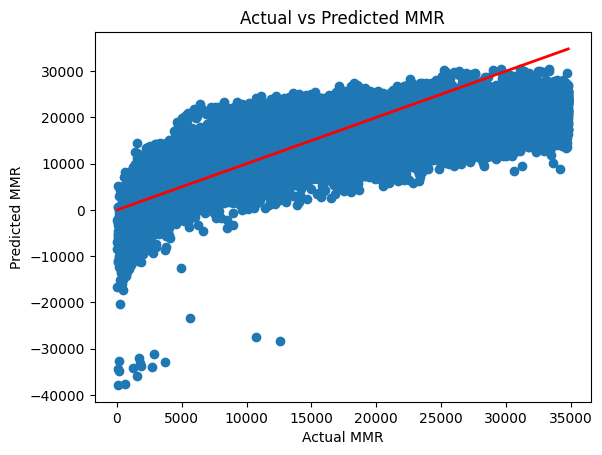

                              Coefficient
year                         3.933691e+03
condition                    2.632752e+02
odometer                    -2.214664e+03
BMW                          3.415569e+15
Chevrolet                    6.010239e+15
...                                   ...
nissan-infiniti lt           4.231100e+15
santander consumer           3.706702e+15
tdaf remarketing             2.508702e+15
the hertz corporation        4.046711e+15
wells fargo dealer services  2.814320e+15

[89 rows x 1 columns]


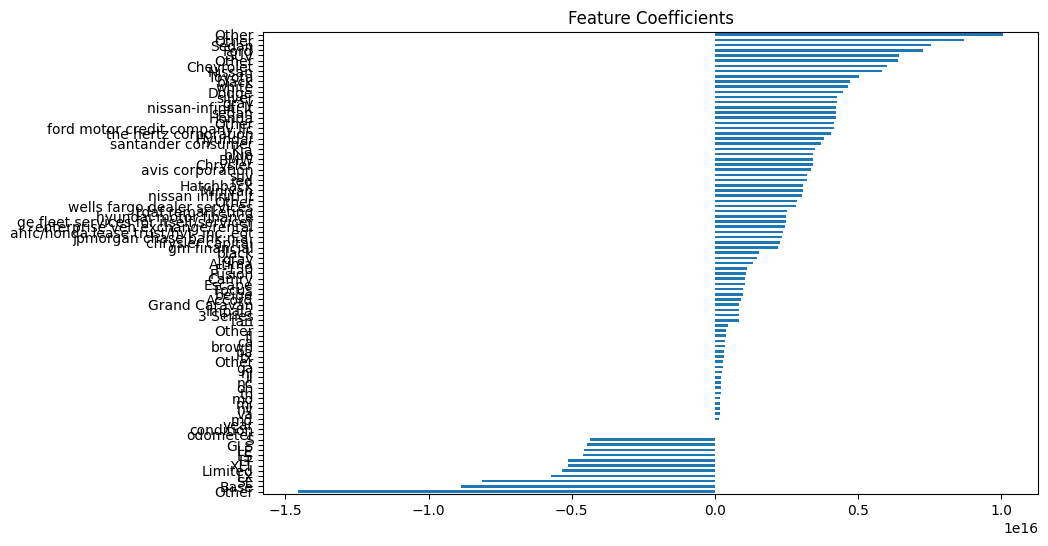

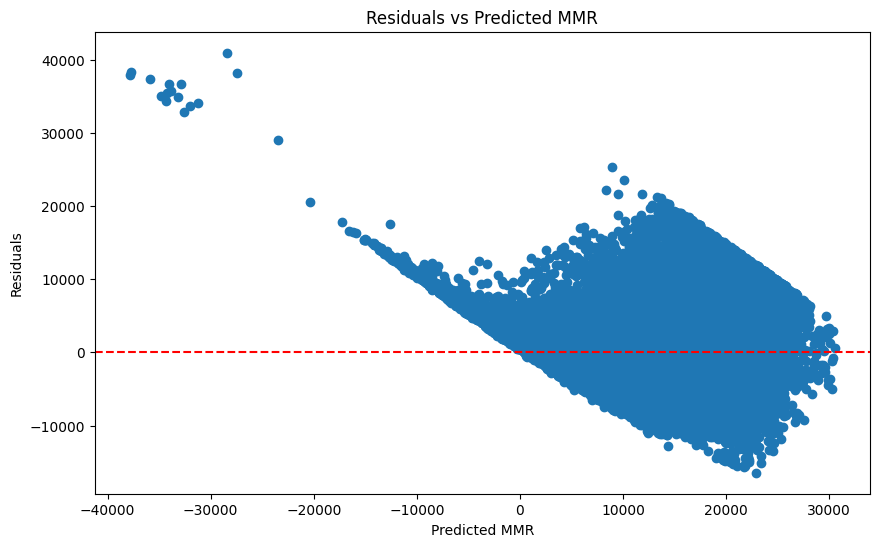

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                        Feature       VIF
0                          year  2.993652
1                     condition  1.202796
2                      odometer  2.722434
3                           BMW       inf
4                     Chevrolet       inf
..                          ...       ...
84           nissan-infiniti lt       inf
85           santander consumer       inf
86             tdaf remarketing       inf
87        the hertz corporation       inf
88  wells fargo dealer services       inf

[89 rows x 2 columns]
         Actual     Predicted         Error
179448  12550.0 -28390.573253  40940.573253
321728    650.0 -37694.573253  38344.573253
103031  10750.0 -27482.573253  38232.573253
406428    100.0 -37826.573253  37926.573253
168800   1550.0 -35850.573253  37400.573253
485268   2725.0 -34008.573253  36733.573253
166054   3725.0 -32898.573253  36623.573253
76882    1850.0 -33817.573253  35667.573253
117972   1200.0 -34248.573253  35448.573253
321671    175.0 -34808.573253  34

In [ ]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
file_path = "./carprices.csv"
df = pd.read_csv(file_path)

# List and drop columns that are less related to the target based on judgement
cols_to_drop = ['transmission', 'sellingprice', 'saledate', 'vin']
df.drop(cols_to_drop, axis=1, inplace=True)

# Drop rows with missing target and other important features
df.dropna(subset=['state', 'make', 'model', 'trim', 'body', 'condition', 'odometer', 'color', 'interior', 'mmr'], inplace=True)

# Handle duplicates
df.drop_duplicates(inplace=True)

# Outlier detection using IQR
Q1 = df['mmr'].quantile(0.25)
Q3 = df['mmr'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['mmr'] >= (Q1 - 1.5 * IQR)) & (df['mmr'] <= (Q3 + 1.5 * IQR))]

def one_hot_encode(df, column, top_n):
    frequency_counts = df[column].value_counts()
    top_items = frequency_counts.nlargest(top_n).index.tolist()
    df[column] = df[column].apply(lambda x: x if x in top_items else 'Other')
    return pd.get_dummies(df, columns=[column], prefix='', prefix_sep='')

# Apply one-hot encoding to categorical columns
categorical_columns = {
    'make': 10,
    'model': 10,
    'trim': 10,
    'body': 6,
    'state': 15,
    'color': 6,
    'interior': 6,
    'seller': 15
}

for column, top_n in categorical_columns.items():
    df = one_hot_encode(df, column, top_n)

# Final dataframe preparation
df_new = df.replace(False, 0)  # Replace any remaining False values with 0
X = df_new.drop(columns='mmr')
y = df_new['mmr']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print("Training Set Metrics:")
print(f"Mean Absolute Error: {train_mae:.2f}")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}")

print("\nTest Set Metrics:")
print(f"Mean Absolute Error: {test_mae:.2f}")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}")

# Save the model as a pickle file
with open('mmr_predictor_model2.pkl', 'wb') as model_file:
    pickle.dump(linear_model, model_file)

print("Model saved as 'mmr_predictor_model2.pkl'")

# Optional: Cross-validation
cv_scores = cross_val_score(linear_model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE: {-cv_scores.mean():.2f}")

# Optional: Visualizing Predictions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual MMR')
plt.ylabel('Predicted MMR')
plt.title('Actual vs Predicted MMR')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Diagonal line
plt.show()

# Examine model coefficients
coefficients = pd.DataFrame(linear_model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Plotting the coefficients
plt.figure(figsize=(10, 6))
coefficients['Coefficient'].sort_values().plot(kind='barh')
plt.title('Feature Coefficients')
plt.show()

# Residuals Analysis
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted MMR')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted MMR')
plt.show()

# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data)

# Error Analysis
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Error': residuals})
print(error_df.sort_values(by='Error', ascending=False).head(10))  # Show the top 10 largest errors
